# Определение возраста покупателей

## Описание проекта
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## План
* Исследовательский анализ набора фотографий
* Подготовка данных к обучению.
* Обучение нейронной сети и расчет её качества


## Исследовательский анализ данных

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='real_age', ylabel='Density'>

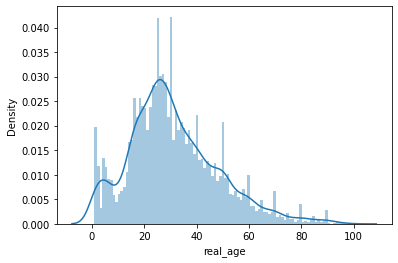

In [3]:
sns.distplot(labels["real_age"],  hist = True, bins=100)

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='real_age'>

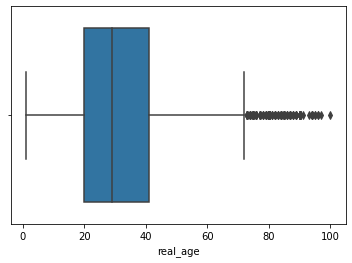

In [4]:
sns.boxplot(labels["real_age"])

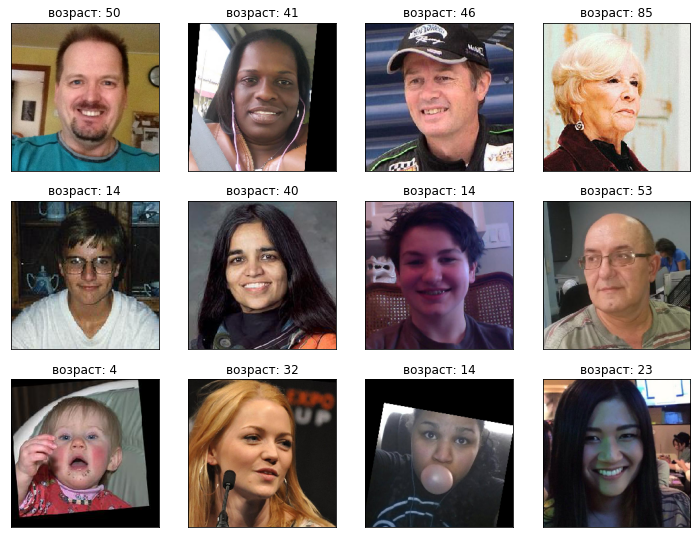

In [5]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title('возраст: ' + str(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**ВЫВОД**

Датасет состоит из 7591 фотографий людей с указанием их возраста.
Людей от 20 до 40 лет в выборке больше всего. Есть пики каждые 10 лет, это скорее всего связано с округлением.
Возраст на фотографиях указан верно. Среди фотографий есть как цветные, так и черно-белые.
Осложнением для обучения модели согут стать объекты, которые закрывают лицо на некоторых фотографиях: рука, очки, головной убор и т.д.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/10
2023-01-14 17:45:01.425316: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-01-14 17:45:03.572535: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 69s - loss: 232.7413 - mae: 10.9597 - val_loss: 678.2421 - val_mae: 20.7434
Epoch 2/10
356/356 - 38s - loss: 84.7196 - mae: 6.9807 - val_loss: 177.5402 - val_mae: 10.0353
Epoch 3/10
356/356 - 38s - loss: 59.1764 - mae: 5.8514 - val_loss: 94.9295 - val_mae: 7.6098
Epoch 4/10
356/356 - 38s - loss: 43.2399 - mae: 5.0292 - val_loss: 76.8756 - val_mae: 6.6557
Epoch 5/10
356/356 - 38s - loss: 32.4230 - mae: 4.3472 - val_loss: 79.7675 - val_mae: 6.5256
Epoch 6/10
356/356 - 38s - loss: 23.4188 - mae: 3.7078 - val_loss: 65.2252 - val_mae: 6.1413
Epoch 7/10
356/356 - 38s - loss: 19.5777 - mae: 3.3718 - val_loss: 78.0317 - val_mae: 6.5583
Epoch 8/10
356/356 - 38s - loss: 15.6285 - mae: 3.0217 - val_loss: 89.6108 - val_mae: 7.3216
Epoch 9/10
356/356 - 38s - loss: 13.6065 - mae: 2.8131 - val_loss: 63.3141 - val_mae: 6.0088
Epoch 10/10
356/356 - 38s - loss: 12.9968 - mae: 2.7392 - val_loss: 63.1370 - val_mae: 5.9666
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Test MAE: 5.9666
119/119 - 9s - loss: 63.1370 - mae: 5.9666
```

## Анализ обученной модели

Для анализа возраста людей по фотографии была использована CCN ResNet50. Было задано 10 эпох и функция оптимизации для нахождения минимума Adam с шагом lr=0.0005. По результату предсказания MAE модели составил 5.9666, что соотвсетвует поставленной задачи (<8)